# A tool for scading in AutoCAD

The main object used in this tool is the PLINE command in autocad.

All shapes are stored as a set of absolue points.

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.ticker as plticker
import copy

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)

In [3]:
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)

## Compiler and Renderer

In [4]:
colours={
    'Conductor':'Red',
    'Conductor2':'Red',
    'Oxide':'White',
    'Resist':'Cyan',
    'Silk':'Yellow'
}

mm = 40 # convertion to mils
inch = 1000 # convertion from in to mils
no_digits = lambda s: ''.join([i for i in s if not i.isdigit()])

env={
    'GRID':[1 * mm],
    'Wire Raidus':10,
    'Alignment Tolerance':15, # was 5 # about 10+
    'Pad Expantion':5,
    'AutoCAD Export':['GRID'],
}

def optimze(**kwargs):
    """Combine overlaping polygons.
    (Ignores the silk layer.)
    And reduce to just a list of polygons.
    (Including the silk layer)"""
    from shapely.geometry import Polygon
    ret={}
    def add_to_layer(l,s):
        #print("l",l)
        #print("s",s)
        if type(s)!=type([]):
            raise ValueError("Recived not a list.")
        if len(s)==0:
            return
        if type(s[0])!=type([]):
            raise ValueError("Recived not a list of points or objects.")
        while len(s[0])==0:
            s.pop(0) # remove empy object from list
            if len(s)==0:
                return # was a list of empty objects
        if type(s[0][0]) in [type(0),type(0.0)]:
            # It's a list of points, lets add the object
            if l not in ret:
                ret[l]=[]
            p=Polygon(s)
            if l!="Silk":
                pos=0
                while pos<len(ret[l]):
                    def inter():
                        ret = False
                        try:
                            ret=p.intersection(ret[l][pos]).area>0
                        except:
                            pass
                        return ret
                    if p.intersection(ret[l][pos]).area>0:
                        p=p.union(ret[l].pop(pos))
                    else:
                        pos+=1
            ret[l].append(p)
            return
        if type(s[0][0])==type([]):
            # it's a list ob objects, recurse
            for obj in s:
                add_to_layer(l,obj)
            return
        raise ValueError("Unknown type",type(s[0][0]))
    for layer_name,layer_items in kwargs.items():
        add_to_layer(layer_name,layer_items)
    for k in ret:
        ret[k]=list(poly.exterior.coords
                    for poly in ret[k])
        ret[k]=list(list([round(pnt[0]),round(pnt[1])]
                         for pnt in shape)
                    for shape in ret[k])
    return ret

def compile(**kwargs):
    ret=''
    def setup():
        e=''
        for k in env['AutoCAD Export']:
            v=env[k]
            e+=k+' '
            if len(v)>0:
                if type(v[0])==type([]):
                    for row in v:
                        for val in row:
                            e+=str(val)+' '
                        e=e[:-1] # trim trailing space
                        e+='\n' # start next row
                else:
                    for val in v:
                        e+=str(val)+' '
                    e=e[:-1] # trim trailing space
            e+='\n' # terminate command
        return e
    ret+=setup()
    shp = optimze(**kwargs)
    for layer_name in shp:
        layer_items=shp[layer_name]
        ret+='-LAYER Make '+layer_name+'\n\n'
        if layer_name in colours:
            ret+='-LAYER Color '+colours[layer_name]+' '+layer_name+'\n\n'
        elif no_digits(layer_name) in colours:
            ret+='-LAYER Color '+colours[no_digits(layer_name)]+' '+layer_name+'\n\n'
        for shape in layer_items:
            cmd="PLINE "
            for point in shape:
                ret+=cmd+"# "+str(round(point[0]))+','+str(round(point[1]))+'\n'
                # Rounding all of the points to make defects more visable
                cmd=""
            ret+='\n'
    print(ret)
    #return ret

def render(**kwargs):
    #loc = plticker.MultipleLocator(base=env['GRID'][0])
    #plt.xaxis.set_major_locator(loc)
    #plt.yaxis.set_major_locator(loc)
    plt.grid(which='major',
             axis='both',
             linestyle=':',
             color='0.75',
             visible=True,
             markevery=5*env['GRID'])
    plt.grid(which='minor',
             axis='both',
             linestyle='-',
             color='0.50',
             visible=True,
             markevery=env['GRID'])
    shp = optimze(**kwargs)
    for layer_name in shp:
        layer_items = shp[layer_name]
        c='Black'
        if layer_name in colours:
            c=colours[layer_name]
        elif no_digits(layer_name) in colours:
            c=colours[no_digits(layer_name)]
        for shape in layer_items:
            plt.plot(*zip(*shape),color=c)

    automin, automax = plt.xlim()
    plt.xlim(automin-0.5, automax+0.5)
    automin, automax = plt.ylim()
    plt.ylim(automin-0.5, automax+0.5)
    plt.gca().set_facecolor('0.30')
    plt.show()

## Utility Functions

### Utility

In [5]:
def wire_reduce(pnts):
    pnts=copy.deepcopy(pnts)
    pos=1
    while pos<len(pnts)-1:
        if (pnts[pos-1][0]==pnts[pos][0] and pnts[pos+1][0]==pnts[pos][0]) or \
           (pnts[pos-1][1]==pnts[pos][1] and pnts[pos+1][1]==pnts[pos][1]):
            pnts.pop(pos)
        else:
            pos+=1
    return pnts

class Memoize:
    def __init__(self, fn):
        self.fn = fn
        self.memo = {}

    def __call__(self, *args):
        if args not in self.memo:
            self.memo[args] = self.fn(*args)
        return self.memo[args]

### Object Creation

In [6]:
def rect(x,y,l,h):
    #return list([x+l*px,y+h*py] for px,py in np.ndindex(2,2))
    if l<0:
        x+=l
        l=-l
    if h<0:
        y+=h
        h=-h
    return [[x  ,y  ],
            [x+l,y  ],
            [x+l,y+h],
            [x  ,y+h],
            [x  ,y  ]]

def wire(points):
    """
    This function assumes that only one dim changes at a time.
    """
    points=copy.deepcopy(points)
    points=wire_reduce(points)
    if len(points)==0:
        return []
    if len(points)==1:
        # simple case
        p=points[0]
        wr=env['Wire Raidus']
        r=[[p[0]-wr,p[1]+wr],
           [p[0]+wr,p[1]+wr],
           [p[0]+wr,p[1]-wr],
           [p[0]-wr,p[1]-wr]]
        r.append(r[0])
        return [r]
    else:
        def direct(p0,p1):
            d=[p1[0]-p0[0],
               p1[1]-p0[1]]
            l2=(d[0]**2+d[1]**2)**.5
            d[0]/=l2
            d[1]/=l2
            return d
        r=[]
        wr=env['Wire Raidus']
        # starting point
        d=direct(points[0],points[1])
        d[0],d[1]=-d[0],-d[1]
        d[0],d[1]=d[0]+d[1],d[1]-d[0]
        d[0]*=wr
        d[1]*=wr
        r.append([points[0][0]+d[0],
                  points[0][1]+d[1]])
        # each middle point
        for p in range(1,len(points)-1):
            d1=direct(points[p],points[p-1])
            d2=direct(points[p],points[p+1])
            d=[d1[0]+d2[0],
               d1[1]+d2[1]]
            if [d1[1],-d1[0]]!=d2:
                d[0],d[1]=-d[0],-d[1]
            d[0]*=wr
            d[1]*=wr
            # this assumes that there is a corner here
            r.append([points[p][0]+d[0],
                      points[p][1]+d[1]])
        # ending point
        d=direct(points[-1],points[-2])
        d[0],d[1]=-d[0],-d[1]
        d[0]*=wr
        d[1]*=wr
        dt=[-d[1],+d[0]]
        r.append([points[-1][0]+d[0]+dt[0],
                  points[-1][1]+d[1]+dt[1]])
        r.append([points[-1][0]+d[0]-dt[0],
                  points[-1][1]+d[1]-dt[1]])
        # walk back
        for p in range(1,len(points)-1)[::-1]:
            d1=direct(points[p],points[p+1])
            d2=direct(points[p],points[p-1])
            d=[d1[0]+d2[0],
               d1[1]+d2[1]]
            if [d1[1],-d1[0]]!=d2:
                d[0],d[1]=-d[0],-d[1]
            d[0]*=wr
            d[1]*=wr
            # this assumes that there is a corner here
            r.append([points[p][0]+d[0],
                      points[p][1]+d[1]])
        # straintg corner
        d=direct(points[0],points[1])
        d[0],d[1]=-d[0],-d[1]
        d[0],d[1]=d[0]-d[1],d[1]+d[0]
        d[0]*=wr
        d[1]*=wr
        r.append([points[0][0]+d[0],
                  points[0][1]+d[1]])
        # compleate loop
        r.append(r[0])
        return [r]
def autoWire(pnts,shape):
    if type(shape)!=type(''):
        raise ValueError("Shape should be a char.")
    if shape=='v':
        if len(pnts)==2:
            # find bottom point
            bot=min(pnts[0][1],pnts[1][1])
            # shift it 3 wireRadi
            bot-=3*env['Wire Raidus']
            return autoWire([pnts[0],bot,pnts[1]],shape)
        if len(pnts)==3:
            return wire([pnts[0],
                         [pnts[0][0],pnts[1]],
                         [pnts[2][0],pnts[1]],
                         pnts[2]])
        raise ValueError("Don't know how to make a "+str(len(pnts))+" point 'v' curve.")
    if shape=='>':
        if len(pnts)==2:
            # find right point
            right=max(pnts[0][0],pnts[1][0])
            # shift it 3 wireRadi
            right+=3*env['Wire Raidus']
            return autoWire([pnts[0],right,pnts[1]],shape)
        if len(pnts)==3:
            return wire([pnts[0],
                         [pnts[1],pnts[0][0]],
                         [pnts[1],pnts[2][0]],
                         pnts[2]])
        raise ValueError("Don't know how to make a "+str(len(pnts))+" point '>' curve.")
    if shape=='^':
        if len(pnts)==2:
            # find top point
            top=max(pnts[0][1],pnts[1][1])
            # shift it 3 wireRadi
            top+=3*env['Wire Raidus']
            return autoWire([pnts[0],top,pnts[1]],shape)
        if len(pnts)==3:
            return wire([pnts[0],
                         [pnts[0][0],pnts[1]],
                         [pnts[2][0],pnts[1]],
                         pnts[2]])
        raise ValueError("Don't know how to make a "+str(len(pnts))+" point '^' curve.")
    if shape=='<':
        if len(pnts)==2:
            # find left point
            left=min(pnts[0][0],pnts[1][0])
            # shift it 3 wireRadi
            left-=3*env['Wire Raidus']
            return autoWire([pnts[0],left,pnts[1]],shape)
        if len(pnts)==3:
            return wire([pnts[0],
                         [pnts[1],pnts[0][0]],
                         [pnts[1],pnts[2][0]],
                         pnts[2]])
        raise ValueError("Don't know how to make a "+str(len(pnts))+" point '<' curve.")
    if shape=='wide-s':
        f='y-first'
        if abs(pnts[0][0]-pnts[-1][0])>abs(pnts[0][1]-pnts[-1][1]):
            f='x-first'
        if len(pnts)==2:
            pnts=[pnts[0],
                  [(pnts[0][0]+pnts[1][0])/2,(pnts[0][1]+pnts[1][1])/2],
                  pnts[1]]
        if len(pnts)==3:
            return [autoWire([pnts[0],pnts[1]],f),
                    autoWire([pnts[2],pnts[1]],f)]
        raise ValueError("Don't know how to make a "+str(len(pnts))+" point 'wide-s' curve.")
    if shape=='narrow-s':
        f='x-first'
        if abs(pnts[0][0]-pnts[-1][0])>abs(pnts[0][1]-pnts[-1][1]):
            f='y-first'
        if len(pnts)==2:
            pnts=[pnts[0],
                  [(pnts[0][0]+pnts[1][0])/2,(pnts[0][1]+pnts[1][1])/2],
                  pnts[1]]
        if len(pnts)==3:
            return [autoWire([pnts[0],pnts[1]],f),
                    autoWire([pnts[2],pnts[1]],f)]
        raise ValueError("Don't know how to make a "+str(len(pnts))+" point 'narrow-s' curve.")
    if shape=='x-first':
        if len(pnts)==2:
            return wire([pnts[0],
                        [pnts[1][0],pnts[0][1]],
                        pnts[1]])
        raise ValueError("Don't know how to make a "+str(len(pnts))+" point 'x-first' curve.")
    if shape=='y-first':
        if len(pnts)==2:
            return wire([pnts[0],
                        [pnts[0][0],pnts[1][1]],
                        pnts[1]])
        raise ValueError("Don't know how to make a "+str(len(pnts))+" point 'y-first' curve.")
    raise ValueError("Don't know how to make a '"+shape+"' curve.")

### Object Inspection

In [7]:
def top_right(obj):
    if type(obj[0][0]) in [type(1),type(1.0)]:
        return [max(p[0] for p in obj),
                max(p[1] for p in obj)]
    return top_right(list(top_right(s) for s in obj))
def bot_right(obj):
    if type(obj[0][0]) in [type(1),type(1.0)]:
        return [max(p[0] for p in obj),
                min(p[1] for p in obj)]
    return bot_right(list(bot_right(s) for s in obj))
def top_left(obj):
    if type(obj[0][0]) in [type(1),type(1.0)]:
        return [min(p[0] for p in obj),
                max(p[1] for p in obj)]
    return top_left(list(top_left(s) for s in obj))
def bot_left(obj):
    if type(obj[0][0]) in [type(1),type(1.0)]:
        return [min(p[0] for p in obj),
                min(p[1] for p in obj)]
    return bot_left(list(bot_left(s) for s in obj))
def top_center(obj):
    tl=top_left(obj)
    tr=top_right(obj)
    return [(tl[0]+tr[0])/2,tr[1]]
def right_center(obj):
    tr=top_right(obj)
    br=bot_right(obj)
    return [tr[0],(tr[1]+br[1])/2]
def bot_center(obj):
    bl=bot_left(obj)
    br=bot_right(obj)
    return [(bl[0]+br[0])/2,br[1]]
def left_center(obj):
    tl=top_left(obj)
    bl=bot_left(obj)
    return [tl[1],(tl[0]+bl[0])/2]
def bound_rect(obj):
    bl=bot_left(obj)
    tl=top_left(obj)
    tr=top_right(obj)
    br=bot_right(obj)
    return [bl,tl,tr,br]
def center(obj):
    rect=bound_rect(obj)
    return [(rect[0][0]+rect[1][0]+rect[2][0]+rect[3][0])/4,
            (rect[0][1]+rect[1][1]+rect[2][1]+rect[3][1])/4]
def MinWidth(rect,percent=False):
    """Assumes param is a rect.
    """
    if len(rect)!=5:
        raise ValueError("Nuu, that's not a rectangle!")
    # find the short side
    pnts=list(zip(rect[:-1],rect[1:]))
    xdelta=round(min(list(delta
                          for pair in pnts
                          for delta in [abs(pair[1][0]-pair[0][0])]
                          if delta!=0)))
    ydelta=round(min(list(delta
                          for pair in pnts
                          for delta in [abs(pair[1][1]-pair[0][1])]
                          if delta!=0)))
    return min(ydelta,xdelta)

### Shape and Object Transforms

In [8]:
def move(obj,pos):
    return list(list(list(p[n]+pos[n] 
                          for n in range(len(p)))
                     for p in shape)
                for shape in obj)

def rotate90(obj,pivot=None):
    if pivot==None:
        pivot=[
            min(point[0] for shape in obj for point in shape),
            min(point[1] for shape in obj for point in shape)
        ]
    ret=[]
    for shape in obj:
        ret.append([])
        for point in shape:
            ret[-1].append([
                pivot[0]-(point[1]-pivot[1]),
                pivot[1]+(point[0]-pivot[0])
            ])
    return ret
def rotate270(obj,pivot=None):
    if pivot==None:
        pivot=[
            min(point[0] for shape in obj for point in shape),
            min(point[1] for shape in obj for point in shape)
        ]
    ret=[]
    for shape in obj:
        ret.append([])
        for point in shape:
            ret[-1].append([
                pivot[0]+(point[1]-pivot[1]),
                pivot[1]-(point[0]-pivot[0])
            ])
    return ret

def rotate(obj,amount,pivot=None):
    """Amount is in quarter turns"""
    amount%=4
    if amount==0:
        return obj
    elif amount==1:
        return rotate90(obj,pivot)
    elif amount==2:
        return rotate90(rotate90(obj,pivot),pivot)
    elif amount==3:
        return rotate270(obj,pivot)
    else:
        raise ValueError("Unknown number",amount)

def point_chanonical(s):
    """
    remove inline points
    remove small lumps
    """
    s=copy.deepcopy(s)
    if s[-1]!=s[0]:
        s.append(s[0])
    pnt=1
    while pnt<len(s)-1:
        """if a[pnt]==a[pnt-1]:
            a.pop(pnt)
            continue
        vb=[a[pnt-1][0]-a[pnt][0],
            a[pnt-1][1]-a[pnt][1]]
        vf=[a[pnt+1][0]-a[pnt][0],
            a[pnt+1][1]-a[pnt][1]]
        cross=vf[0]*vb[1]-vf[1]*vb[0]
        if cross==0:
            a.pop(pnt)
            continue"""
        if (s[pnt][0]==s[pnt-1][0] and s[pnt][0]==s[pnt+1][0]) or \
           (s[pnt][1]==s[pnt-1][1] and s[pnt][1]==s[pnt+1][1]):
            s.pop(pnt)
            continue
        pnt+=1
    if (s[0][0]==s[1][0] and s[0][0]==s[-2][0]) or \
       (s[0][1]==s[1][1] and s[0][1]==s[-2][1]):
        s.pop(0)
        s.pop(-1)
        s.append(s[0])
    pass
    return s

def smooth(s):
    pass

def pretty(s):
    return point_chanonical(s)
def flatten(o):
    if type(o)!=type([]):
        raise ValueError("That's not an object, that's a",str(type(a)))
    if len(o)==0:
        return [] # was empty
    if type(o[0])!=type([]):
        raise ValueError("That's not a list of points/objects, that a list of",str(type(a[0])))
    pos=0
    while pos<len(o):
        if len(o[pos])==0:
            o.pop(pos)
        else:
            pos+=1
    if len(o)==0:
        return [] # was disguised and empty
    if type(o[0][0]) in [type(0),type(0.0)]:
        # was a list of points
        return [o]
    ret=[]
    for s in o:
        # TODO: havn't check ed that s[0][0] exists
        if type(s[0][0]) in [type(0),type(0.0)]:
            # is a list of points
            ret+=[o]
        else:
            # is a list of shapes
            ret+=flatten(s)
    ret=optimze(ret=ret)['ret']
    ret=list(pretty(o) for o in ret)
    return ret

def expand(obj,amount):
    obj=flatten(copy.deepcopy(obj))
    #obj=optimze(obj=obj)['obj']
    ret=[]
    def cw_not_ccw(pnts):
        rot=0
        for pnt in range(-1,len(pnts)-1):
            vb=[pnts[pnt-1][0]-pnts[pnt][0],
                pnts[pnt-1][1]-pnts[pnt][1]]
            vf=[pnts[pnt+1][0]-pnts[pnt][0],
                pnts[pnt+1][1]-pnts[pnt][1]]
            cross=vf[0]*vb[1]-vf[1]*vb[0]
            if cross!=0:
                rot+=cross/abs(cross)
        return rot<0
    for shape in obj:
        ret.append([])
        shape=wire_reduce(shape)
        if shape[0]==shape[-1]:
            shape=shape[:-1]
        cw=cw_not_ccw(shape)
        for point in range(-1,len(shape)-1):# all the points but with better wrapping
            Dm1=[shape[point-1][0]-shape[point][0],shape[point-1][1]-shape[point][1]]
            Dm1=[Dm1[0]/((Dm1[0]**2+Dm1[1]**2)**.5),Dm1[1]/((Dm1[0]**2+Dm1[1]**2)**.5)]
            Dp1=[shape[point+1][0]-shape[point][0],shape[point+1][1]-shape[point][1]]
            Dp1=[Dp1[0]/((Dp1[0]**2+Dp1[1]**2)**.5),Dp1[1]/((Dp1[0]**2+Dp1[1]**2)**.5)]
            if cw:    
                # (p[-1] rot 1cw)/len+(p[1] rot -1cw)/len
                Dm1=[Dm1[1],-Dm1[0]]
                Dp1=[-Dp1[1],Dp1[0]]
            else:
                # (p[-1] rot -1cw)/len+(p[1] rot 1cw)/len
                Dm1=[-Dm1[1],Dm1[0]]
                Dp1=[Dp1[1],-Dp1[0]]
            delta=[Dm1[0]+Dp1[0],Dm1[1]+Dp1[1]]
            pnt=[shape[point][0]+amount*delta[0],
                 shape[point][1]+amount*delta[1]]
            ret[-1].append(pnt)
    return flatten(ret)
        
def alignment_pad(center_or_rect):
    #center_or_rect=copy.deepcopy(center_or_rect)
    if len(center_or_rect)==2:
        c = center_or_rect
        return [rect(c[0]-env['Wire Raidus']-env['Alignment Tolerance'],
                     c[1]-env['Wire Raidus']-env['Alignment Tolerance'],
                     2*env['Wire Raidus']+2*env['Alignment Tolerance'],
                     2*env['Wire Raidus']+2*env['Alignment Tolerance'])]
    if len(center_or_rect)==5:
        r=center_or_rect
        c=center(r)
        g=max([env['Alignment Tolerance'],
               env['Wire Raidus']-MinWidth(r)])
        return list([g*(p[0]-c[0])/abs(p[0]-c[0])+p[0],
                     g*(p[1]-c[1])/abs(p[1]-c[1])+p[1]]
                    for p in r)
    raise ValueError("Not a point or rectangle")

def solder_pad(rect):
    if len(rect)==5:
        c=center(rect)
        g=max([env['Pad Expantion'],
               env['Wire Raidus']-MinWidth(rect)])
        return list([g*(p[0]-c[0])/abs(p[0]-c[0])+p[0],
                     g*(p[1]-c[1])/abs(p[1]-c[1])+p[1]]
                    for p in rect)
    raise ValueError("Not a rectangle")

### Group Transforms

#### This one

In [9]:
from shapely.geometry import Polygon,MultiPolygon
def Union(a,b):
    return [a,b]

def intersection(a,b):
    a=flatten(copy.deepcopy(a))
    b=flatten(copy.deepcopy(b))
    a=list([p,[]] for p in a)
    b=list([p,[]] for p in b)
    full=MultiPolygon(a)
    minus=MultiPolygon(b)
    ret=full.intersection(minus)
    #print("type(ret)",type(ret))
    r=[]
    if str(type(ret))=="<class 'shapely.geometry.polygon.Polygon'>":
        r.append(list([c[0],c[1]]
                      for c in ret.exterior.coords))
    elif str(type(ret))=="<class 'shapely.geometry.linestring.LineString'>":
        return []
    else:
        for p in ret:
            #print("type(p)",type(p))
            if str(type(p))=="<class 'shapely.geometry.linestring.LineString'>":
                #print("durped")
                continue
            r.append(list([c[0],c[1]]
                          for c in p.exterior.coords))
    return r
def without(a,b):
    a=flatten(copy.deepcopy(a))
    b=flatten(copy.deepcopy(b))
    a=list([p,[]] for p in a)
    b=list([p,[]] for p in b)
    full=MultiPolygon(a)
    minus=MultiPolygon(b)
    ret=full.difference(minus)
    r=[]
    if str(type(ret))=="<class 'shapely.geometry.polygon.Polygon'>":
        r.append(list([c[0],c[1]]
                      for c in ret.exterior.coords))
    elif str(type(ret))=="<class 'shapely.geometry.linestring.LineString'>":
        return []
    else:
        for p in ret:
            #print("type(p)",type(p))
            if str(type(p))=="<class 'shapely.geometry.linestring.LineString'>":
                #print("durped")
                continue
            r.append(list([c[0],c[1]]
                          for c in p.exterior.coords))
    return r

#### noped

from shapely.geometry import Polygon,MultiPolygon
def Union(a,b):
    return [a,b]
def intersection(a,b):
    a=flatten(copy.deepcopy(a))
    b=flatten(copy.deepcopy(b))
    #a=list([p,[]] for p in a)
    #b=list([p,[]] for p in b)
    a=a[0]
    b=b[0]
    full=Polygon(a)#full=MultiPolygon(a)
    minus=Polygon(b)#minus=MultiPolygon(b)
    ret=full.intersection(minus)
    #print("type(ret)",type(ret))
    r=[]
    #for p in ret:
    #    #print("type(p)",type(p))
    #    if str(type(p))=="<class 'shapely.geometry.linestring.LineString'>":
    #        #print("durped")
    #        continue
    #    r.append(list([c[0],c[1]]
    #                  for c in p.exterior.coords))
    if str(type(ret))=="<class 'shapely.geometry.linestring.LineString'>":
        #print("durped")
        return []
    r.append(list([c[0],c[1]]
                  for c in ret.exterior.coords))
    return r
def without(a,b):
    a=flatten(copy.deepcopy(a))
    b=flatten(copy.deepcopy(b))
    #a=list([p,[]] for p in a)
    #b=list([p,[]] for p in b)
    a=a[0]
    b=b[0]
    full=Polygon(a)#full=MultiPolygon(a)
    minus=Polygon(b)#minus=MultiPolygon(b)
    ret=full.difference(minus)
    r=[]
    if str(type(ret))=="<class 'shapely.geometry.collection.GeometryCollection'>":
        for p in ret:
            r.append(list([c[0],c[1]]
                          for c in p.exterior.coords))
    else:
        r.append(list([c[0],c[1]]
                      for c in ret.exterior.coords))
    return r

## Component Libary

In [10]:
CeramicBoundry=[rect(0,0,.6*inch,.6*inch),
                rect(2*env['Wire Raidus'],
                     2*env['Wire Raidus'],
                     .6*inch-4*env['Wire Raidus'],
                     .6*inch-4*env['Wire Raidus'])]

LM324_Silk=[
    rect(0,0,8.6 * mm, 3.9 * mm), # modify with notch
   *list(rect(1.27 * mm * leg + (8.6-(1.27*(7-1)+.4))/2*mm,
              3.90 * mm * is_top,
              0.40 * mm,
              1.20 * mm *2*(is_top-.5))
         for is_top in [0,1]
         for leg in range(7)[::(1-2*is_top)])
]

def silk_to_pad(obj):
    """Assumes that the obj is of the form [boundry,contact,contact,...]."""
    recs=obj[1:]
    recs=list(solder_pad(foot) for foot in recs)
    return recs

LM324_Pad=silk_to_pad(LM324_Silk)

def cap_silk(ID):
    """Returns the outline and a silk of the pads."""
    if ID=="293D226X0016D2T":
        # https://www.mouser.com/datasheet/2/427/293d-239871.pdf
        # D case
        return [rect(0,0,7.3 * mm,4.3 * mm),
                rect(0,(4.3-2.4)/2*mm,1.3*mm,2.4*mm),
                rect((7.3-1.4)*mm,(4.3-2.4)/2*mm,1.3*mm,2.4*mm)]
    if ID=="35MC105KBTER":
        # https://www.datasheets360.com/pdf/-6726743588809183636
        # UCC Case B
        return [rect(0.2 * mm, 0.0 * mm, 4.3 * mm, 2.6 * mm),
                rect(0.0 * mm, 0.4 * mm, 0.9 * mm, 1.8 * mm),
                rect(3.8 * mm, 0.4 * mm, 0.9 * mm, 1.8 * mm)]
    else:
        raise ValueError("Unknown cap "+str(ID))

def cap_pad(ID):
    return silk_to_pad(cap_silk(ID))
    #make the right size
    return recs

def resistor_silk(ID):
    """Returns the outline and a silk of the pads."""
    if ID=='KTR03EZPF1005':
        return [rect(0,0,1.6*mm,.8*mm),
                rect(0,0,.3*mm,.8*mm),
                rect(1.3*mm,0,.3*mm,.8*mm)]
    if ID=="0603":
        return [rect(0,0,1.6*mm,0.8*mm),
                rect(0,0,.3*mm,.8*mm),
                rect(1.3*mm,0,.3*mm,.8*mm)]
    if ID=="1206":
        return [rect(0,0,3.2*mm,1.6*mm),
                rect(0,0,.5*mm,1.6*mm),
                rect(2.7*mm,0,.5*mm,1.6*mm)]
    else:
        raise ValueError("Unknown resistor "+str(ID))

def resistor_pad(ID):
    return silk_to_pad(resistor_silk(ID))
    #make the right size
    return recs

In [11]:
gator_pad=[rect(0,0,2*mm,4*mm)]

# Scad File

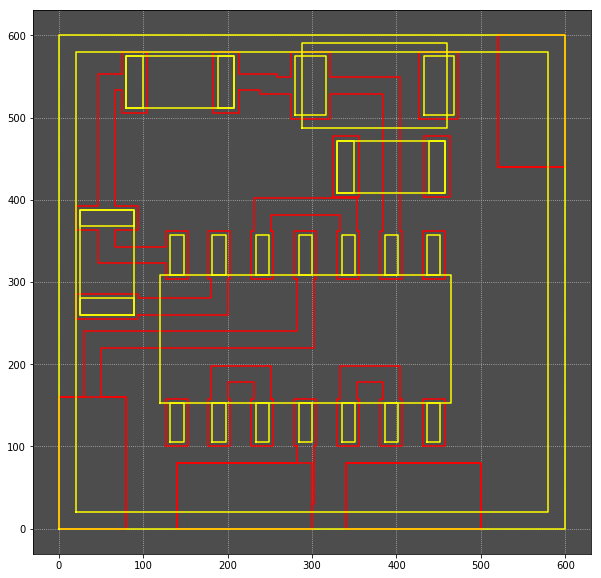

In [12]:
##
# Place Pads
##

Vpos_pad=move(rotate(gator_pad,1),[7.5*mm,0*mm])
Vneg_pad=move(gator_pad,[0*mm,0*mm])
GND_pad=move(rotate(gator_pad,1),[12.5*mm,0*mm])
VSout_pad=[]#move(gator_pad,[0*mm,0*mm])
VTout_pad=move(gator_pad,[CeramicBoundry[0][2][0]-gator_pad[0][2][0],11*mm])

##
# Create and Position Components
##

wr=env['Wire Raidus']
at=env['Alignment Tolerance']
pa=env['Pad Expantion']

U1_pad=LM324_Pad
U1_silk=LM324_Silk
C1_pad=cap_pad("35MC105KBTER")
C1_silk=cap_silk("35MC105KBTER")
R1_pad=resistor_pad("1206")
R1_silk=resistor_silk("1206")
R2_pad=resistor_pad("1206")
R2_silk=resistor_silk("1206")
R3_pad=resistor_pad("1206")
R3_silk=resistor_silk("1206")

U1Pos=[3*mm,top_center(Vpos_pad)[1]+2*wr-bot_center(U1_pad)[1]]
U1rot=0
U1_pad=move(rotate(U1_pad,U1rot),U1Pos)
U1_silk=move(rotate(U1_silk,U1rot),U1Pos)

C1Pos=[7*mm,CeramicBoundry[1][2][1]-C1_pad[0][2][1]]
R2Pos=[R2_pad[0][2][1]+CeramicBoundry[1][0][0],6.5*mm]
R3Pos=[2*mm,CeramicBoundry[1][2][1]-R3_pad[0][2][1]]

C1rot=0
R2rot=1
R3rot=0

C1_pad=move(rotate(C1_pad,C1rot,[0,0]),C1Pos)
C1_silk=move(rotate(C1_silk,C1rot,[0,0]),C1Pos)
R2_pad=move(rotate(R2_pad,R2rot,[0,0]),R2Pos)
R2_silk=move(rotate(R2_silk,R2rot,[0,0]),R2Pos)
R3_pad=move(rotate(R3_pad,R3rot,[0,0]),R3Pos)
R3_silk=move(rotate(R3_silk,R3rot,[0,0]),R3Pos)

R1rot=0
R1Pos=[bot_center(C1_silk[0])[0]-top_center(R1_silk[0])[0]+.5*mm,
       bot_center(C1_silk[0])[1]-top_center(R1_silk[0])[1]-wr-pa]
R1_pad=move(rotate(R1_pad,R1rot,[0,0]),R1Pos)
R1_silk=move(rotate(R1_silk,R1rot,[0,0]),R1Pos)


##
# Connect Compnents and Pads
##

jumps=[]
solder_dams=[]
covers=[]

op1_short=autoWire([top_center(U1_pad[1]),top_center(U1_pad[2])],'^')
op2_short=autoWire([top_center(U1_pad[4]),top_center(U1_pad[5])],'^')
Vpos_node=autoWire([center(U1_pad[3]),center(Vpos_pad)],'y-first')
Vneg_node=autoWire([center(U1_pad[10]),
                    [center(R2_pad[0])[0],center(R2_pad[0])[1]-1*mm],
                    center(Vneg_pad[0])],
                   'wide-s')
VSpos_node=autoWire([center(R2_pad[0]),center(U1_pad[12])],'x-first')
VSout_node=[autoWire([center(R2_pad[1]),center(U1_pad[13])],'y-first'),
            autoWire([center(R2_pad[1]),center(R3_pad[0])],'y-first')]
VTneg_node=[autoWire([center(R3_pad[1]),center(C1_pad[0])],'wide-s'),
            autoWire([center(C1_pad[0]),center(U1_pad[8])],'x-first')]
GND_node=[autoWire([top_center(U1_pad[11]),top_center(U1_pad[9])],'^'),
         ]

#VTout_node=[autoWire([center(C1_pad[1]),center(VTout_pad)],'x-first'),
#            autoWire([center(R1_pad[0]),center(U1_pad[7])],'x-first'),
#            autoWire([center(VTout_pad),center(R1_pad[0])],'wide-s')]

VTout_node=[]
jmp_pads=[]
"""
Vpos_node=[autoWire([center(U1_pad[3]),center(Vpos_pad)],'y-first')] # Vpos, u1p4
Vneg_node=autoWire([center(U1_pad[10]),
                    [center(R2_pad[0])[0],center(R2_pad[0])[1]-1*mm],
                    center(Vneg_pad[0])],
                   'wide-s')
VSout_node=[autoWire([top_center(R2_pad[1]),top_center(U1_pad[13])],'^'),
            autoWire([center(R2_pad[1]),center(R3_pad[0])],'y-first')]
VTout_node=[autoWire([center(C1_pad[1]),center(VTout_pad)],'x-first'),
            autoWire([center(VTout_pad),center(U1_pad[7])],'wide-s'),
            autoWire([center(VTout_pad),center(R1_pad[0])],'wide-s')] # u1p8, C1pos, R1neg, VTout
VTneg_node=[autoWire([center(R3_pad[1]),center(C1_pad[0])],'wide-s'),
            autoWire([center(C1_pad[0]),center(U1_pad[8])],'x-first')]
VSpos_node=[center(R2_pad[0]),
            [center(R2_pad[0])[0],(center(R2_pad[0])[1]+center(U1_pad[12])[1])/2],
            [center(U1_pad[12])[0],(center(R2_pad[0])[1]+center(U1_pad[12])[1])/2],
            center(U1_pad[12]),] # u1p12, R1pos, R2neg
VSpos_node=[wire(VSpos_node)]
GND_node=[autoWire([top_center(U1_pad[11]),top_center(U1_pad[9])],'^'),
          wire([center(U1_pad[9]),
                [center(U1_pad[9])[0],center(R2_pad[0])[1]-1*mm],
                [top_right(U1_pad[6])[0]+3*env['Wire Raidus'],center(R2_pad[0])[1]-1*mm],
                [top_right(U1_pad[6])[0]+3*env['Wire Raidus'],center(GND_pad[0])[1]]])]


jumps+=[alignment_pad([center(U1_pad[11])[0],top_center(U1_pad[2])[1]+6*wr+at]),
        alignment_pad([center(U1_pad[8])[0],top_center(U1_pad[5])[1]+6*wr+at])]
VSpos_node+=jumps
covers.append([center(U1_pad[10])[0],center(jumps[-1])[1]])
covers.append([center(U1_pad[9])[0],center(jumps[-1])[1]])
#jumps+=[wire([[center(U1_pad[11])[0],center(R2_pad[0])[1]],
#              [center(U1_pad[8])[0],center(R2_pad[0])[1]]])]
jumps+=[autoWire([center(jumps[-2]),center(jumps[-1])],'x-first')]
VSpos_node+=[autoWire([center(U1_pad[12]),
                       [center(U1_pad[11])[0],center(R2_pad[0])[1]]],
                      'y-first'),
             autoWire([[center(U1_pad[8])[0],center(R2_pad[0])[1]],
                       top_center(R1_pad[1])]
                      ,'^')]
"""
pads=[
    Vpos_pad,
    Vneg_pad,
    GND_pad,
    VSout_pad,
    VTout_pad,
    U1_pad,
    C1_pad,
    R1_pad,
    R2_pad,
    R3_pad,
    jmp_pads,
]
wires=[
    Vpos_node,
    Vneg_node,
    VSout_node,
    VTout_node,
    VTneg_node,
    VSpos_node,
    GND_node,
    op1_short,
    op2_short,
]

keepout=expand(pads,2*wr)
def sd(w,p):
    #return w
    #return [expand(p,-2*wr),expand(p,2*wr)]
    #return intersection(w,[expand(p,-2*wr),expand(p,2*wr)])
    #return without(intersection(w,[expand(p,-2*wr),expand(p,2*wr)]),
    #               [expand(p,-1*wr),expand(p,1*wr)])
    #return [expand(w,2*at),expand(w,-2*at)]
    return without(without(intersection(expand(w,-2*at),
                                        [expand(p,-4*wr),expand(p,4*wr)]),
                           [expand(p,-2*wr),expand(p,2*wr)]),
                   keepout)

#solder_dams=expand(pads,2*wr)
#solder_dams=intersection(expand(wires,wr),expand(pads,2*wr))
"""
solder_dams=list(sd(w,p)
                 for w,p in [
                     [VTneg_node, C1_pad[0]],
                     [VTout_node, C1_pad[1]],
                     [VTout_node, R1_pad[0]],
                     [VSpos_node, R1_pad[1]],
                     [VSpos_node, R2_pad[0]],
                     [VSout_node, R2_pad[1]],
                     [VSout_node, R3_pad[0]],
                     [VTneg_node, R3_pad[1]],
                     #[         , U1_pad[0]],
                     [op1_short , U1_pad[1]],
                     [op1_short , U1_pad[2]],
                     [Vpos_node , U1_pad[3]],
                     [op2_short , U1_pad[4]],
                     [op2_short , U1_pad[5]],
                     #[         , U1_pad[6]],
                     [VTout_node, U1_pad[7]],
                     [VTneg_node, U1_pad[8]],
                     [GND_node  , U1_pad[9]],
                     [Vneg_node , U1_pad[10]],
                     [GND_node  , U1_pad[11]],
                     [VSpos_node, U1_pad[12]],
                     [VSout_node, U1_pad[13]],
                 ])
"""
##
# Build Layers
##

Conductor1=[
    wires,
    pads,
]
covers=list(alignment_pad(c)
            for c in covers)
Oxide=[
    #solder_dams,
    covers,
]
Conductor2=[
    jumps,
    Vpos_pad,
    Vneg_pad,
    GND_pad,
    VSout_pad,
    VTout_pad,
]
Silk=[
    CeramicBoundry,
    U1_silk,
    C1_silk,
    R1_silk,
    R2_silk,
    R3_silk,
]

render(Conductor1=Conductor1,Oxide=Oxide,Conductor2=Conductor2,Silk=Silk)
#compile(Conductor1=Conductor1,Oxide=Oxide,Conductor2=Conductor2,Silk=Silk)

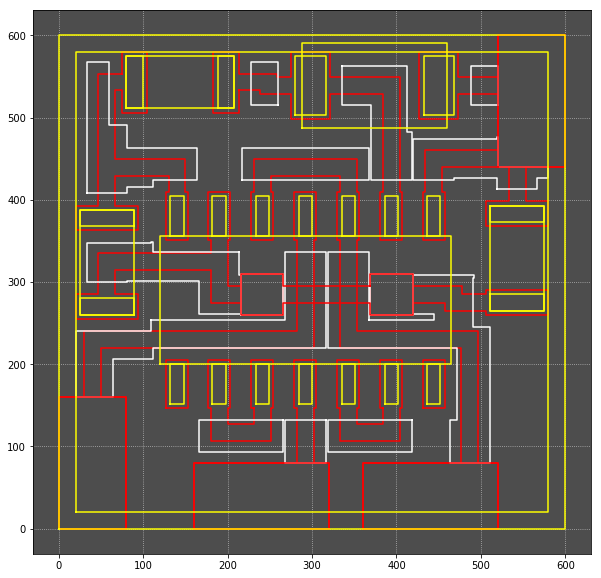

In [13]:
##
# Place Pads
##

Vpos_pad=move(rotate(gator_pad,1),[8*mm,0*mm])
Vneg_pad=move(gator_pad,[0*mm,0*mm])
GND_pad=move(rotate(gator_pad,1),[13*mm,0*mm])
VSout_pad=[]#move(gator_pad,[0*mm,0*mm])
VTout_pad=move(gator_pad,[CeramicBoundry[0][2][0]-gator_pad[0][2][0],11*mm])

##
# Create and Position Components
##

U1_pad=LM324_Pad
U1_silk=LM324_Silk
C1_pad=cap_pad("35MC105KBTER")
C1_silk=cap_silk("35MC105KBTER")
R1_pad=resistor_pad("1206")
R1_silk=resistor_silk("1206")
R2_pad=resistor_pad("1206")
R2_silk=resistor_silk("1206")
R3_pad=resistor_pad("1206")
R3_silk=resistor_silk("1206")

U1Pos=[3*mm,5*mm]
U1rot=0
U1_pad=move(rotate(U1_pad,U1rot),U1Pos)
U1_silk=move(rotate(U1_silk,U1rot),U1Pos)

C1Pos=[7*mm,CeramicBoundry[1][2][1]-C1_pad[0][2][1]]
R2Pos=[R2_pad[0][2][1]+CeramicBoundry[1][0][0],6.5*mm]
R3Pos=[2*mm,CeramicBoundry[1][2][1]-R3_pad[0][2][1]]

C1rot=0
R2rot=1
R3rot=0

C1_pad=move(rotate(C1_pad,C1rot,[0,0]),C1Pos)
C1_silk=move(rotate(C1_silk,C1rot,[0,0]),C1Pos)
R2_pad=move(rotate(R2_pad,R2rot,[0,0]),R2Pos)
R2_silk=move(rotate(R2_silk,R2rot,[0,0]),R2Pos)
R3_pad=move(rotate(R3_pad,R3rot,[0,0]),R3Pos)
R3_silk=move(rotate(R3_silk,R3rot,[0,0]),R3Pos)

R1rot=-1
R1Pos=[CeramicBoundry[1][2][0]-R1_pad[1][2][1],top_right(R2_pad[1])[1]]
R1_pad=move(rotate(R1_pad,R1rot,[0,0]),R1Pos)
R1_silk=move(rotate(R1_silk,R1rot,[0,0]),R1Pos)

component_pads=[
    U1_pad,
    C1_pad,
    R1_pad,
    R2_pad,
    R3_pad,
]
component_outlines=[
    U1_silk,
    C1_silk,
    R1_silk,
    R2_silk,
    R3_silk,
]

##
# Connect Compnents and Pads
##
wr=env['Wire Raidus']
at=env['Alignment Tolerance']

jump_pads=[]
jumps=[]
solder_dams=[]
covers=[]

Vpos_node=[autoWire([center(U1_pad[3]),center(Vpos_pad)],'y-first')] # Vpos, u1p4
Vneg_node=autoWire([center(U1_pad[10]),
                    [center(R2_pad[0])[0],center(R2_pad[0])[1]-1*mm],
                    center(Vneg_pad[0])],
                   'wide-s')
VSout_node=[autoWire([top_center(R2_pad[1]),top_center(U1_pad[13])],'^'),
            autoWire([center(R2_pad[1]),center(R3_pad[0])],'y-first')]
VTout_node=[autoWire([center(C1_pad[1]),center(VTout_pad)],'x-first'),
            autoWire([center(VTout_pad),center(U1_pad[7])],'wide-s'),
            autoWire([center(VTout_pad),center(R1_pad[0])],'wide-s')] # u1p8, C1pos, R1neg, VTout
VTneg_node=[autoWire([center(R3_pad[1]),center(C1_pad[0])],'wide-s'),
            autoWire([center(C1_pad[0]),center(U1_pad[8])],'x-first')]
VSpos_node=[center(R2_pad[0]),
            [center(R2_pad[0])[0],(center(R2_pad[0])[1]+center(U1_pad[12])[1])/2],
            [center(U1_pad[12])[0],(center(R2_pad[0])[1]+center(U1_pad[12])[1])/2],
            center(U1_pad[12]),] # u1p12, R1pos, R2neg
VSpos_node=[wire(VSpos_node)]
GND_node=[autoWire([top_center(U1_pad[11]),top_center(U1_pad[9])],'^'),
          wire([center(U1_pad[9]),
                [center(U1_pad[9])[0],center(R2_pad[0])[1]-1*mm],
                [top_right(U1_pad[6])[0]+3*env['Wire Raidus'],center(R2_pad[0])[1]-1*mm],
                [top_right(U1_pad[6])[0]+3*env['Wire Raidus'],center(GND_pad[0])[1]]])]

null_pad=alignment_pad([0,0])
jump_pads+=[alignment_pad([center(U1_pad[11])[0],
                           top_center(U1_pad[2])[1]+4*wr+at-bot_center(null_pad)[1]]),
            alignment_pad([center(U1_pad[8])[0],
                           top_center(U1_pad[5])[1]+4*wr+at-bot_center(null_pad)[1]])]
#jumps+=[wire([[center(U1_pad[11])[0],center(R2_pad[0])[1]],
#              [center(U1_pad[8])[0],center(R2_pad[0])[1]]])]
jumps+=[autoWire([center(jump_pads[-2]),center(jump_pads[-1])],'x-first')]
VSpos_node+=[autoWire([center(U1_pad[12]),
                       center(jump_pads[-2])],
                      'y-first'),
             autoWire([center(jump_pads[-1]),
                       center(R1_pad[1])]
                      ,'wide-s')]

op1_short=autoWire([bot_center(U1_pad[1]),bot_center(U1_pad[2])],'v')
op2_short=autoWire([bot_center(U1_pad[4]),bot_center(U1_pad[5])],'v')

two_layer_pads=[
    Vpos_pad,
    Vneg_pad,
    GND_pad,
    VSout_pad,
    VTout_pad,
    jump_pads,
]
pads=[
    component_pads,
    two_layer_pads,
]
wires=[
    Vpos_node,
    Vneg_node,
    VSout_node,
    VTout_node,
    VTneg_node,
    VSpos_node,
    GND_node,
    op1_short,
    op2_short,
]

ugly_fudge=[expand(component_pads,at),two_layer_pads]

#solder_dams=ugly_fudge#expand(pads,at)
#solder_dams=expand(wires,at-1)
#solder_dams=expand(ugly_fudge,1)
solder_dams=without(expand(wires,at-1),ugly_fudge)
solder_dams=intersection(solder_dams,CeramicBoundry[1])
"""
keepout=[expand(pads,2*wr),expand(pads,-2*wr)]
def sd(w,p):
    #return w
    #return [expand(p,-2*wr),expand(p,2*wr)]
    #return intersection(w,[expand(p,-2*wr),expand(p,2*wr)])
    #return without(intersection(w,[expand(p,-2*wr),expand(p,2*wr)]),
    #               [expand(p,-1*wr),expand(p,1*wr)])
    #return [expand(w,2*at),expand(w,-2*at)]
    return without(without(intersection(expand(w,-2*at),
                                        [expand(p,-4*wr),expand(p,4*wr)]),
                           [expand(p,-2*wr),expand(p,2*wr)]),
                   keepout)

solder_dams=list(sd(w,p)
                 for w,p in [
                     [VTneg_node, C1_pad[0]],
                     [VTout_node, C1_pad[1]],
                     [VTout_node, R1_pad[0]],
                     [VSpos_node, R1_pad[1]],
                     [VSpos_node, R2_pad[0]],
                     [VSout_node, R2_pad[1]],
                     [VSout_node, R3_pad[0]],
                     [VTneg_node, R3_pad[1]],
                     #[         , U1_pad[0]],
                     [op1_short , U1_pad[1]],
                     [op1_short , U1_pad[2]],
                     [Vpos_node , U1_pad[3]],
                     [op2_short , U1_pad[4]],
                     [op2_short , U1_pad[5]],
                     #[         , U1_pad[6]],
                     [VTout_node, U1_pad[7]],
                     [VTneg_node, U1_pad[8]],
                     [GND_node  , U1_pad[9]],
                     [Vneg_node , U1_pad[10]],
                     [GND_node  , U1_pad[11]],
                     [VSpos_node, U1_pad[12]],
                     [VSout_node, U1_pad[13]],
                 ])
"""
#solder_dams=list(alignment_pad(sd) for sd in solder_dams)
##
# Build Layers
##

Conductor1=[
    wires,
    pads,
]
Oxide=[
    solder_dams,
    jump_pads,
    covers,
]
Conductor2=[
    jumps,
    two_layer_pads,
]
Silk=[
    CeramicBoundry,
    component_outlines
]

render(Conductor1=Conductor1,Oxide=Oxide,Conductor2=Conductor2,Silk=Silk)
#render(Oxide=Oxide)
#compile(Conductor1=Conductor1,Oxide=Oxide,Conductor2=Conductor2,Silk=Silk)

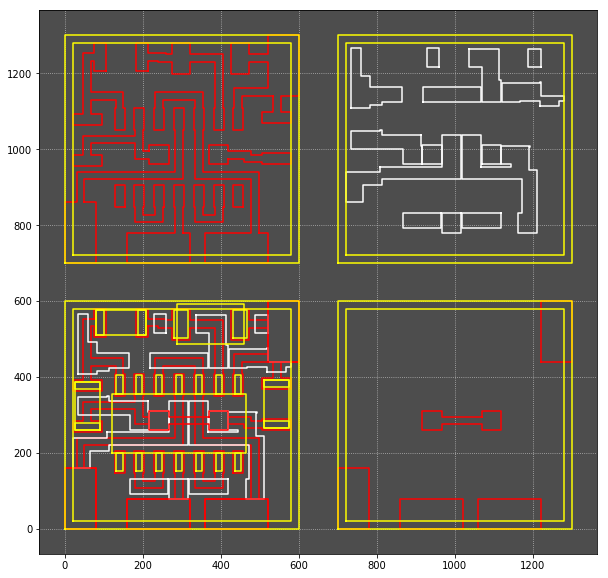

'\ncompile(Conductor1=[Conductor1,\n                    move(flatten(Conductor1),(0,700))],\n        Oxide=[Oxide,\n               move(flatten(Oxide),(700,700))],\n        Conductor2=[Conductor2,\n                    move(flatten(Conductor2),(700,0))],\n        Silk=[Silk,\n              move(CeramicBoundry,(0,700)),\n              move(CeramicBoundry,(700,0)),\n              move(CeramicBoundry,(700,700))])\n#'

In [22]:
render(Conductor1=[Conductor1,
                   move(flatten(Conductor1),(0,700))],
       Oxide=[Oxide,
              move(flatten(Oxide),(700,700))],
       Conductor2=[Conductor2,
                   move(flatten(Conductor2),(700,0))],
       Silk=[Silk,
             move(CeramicBoundry,(0,700)),
             move(CeramicBoundry,(700,0)),
             move(CeramicBoundry,(700,700))])
"""
compile(Conductor1=[Conductor1,
                    move(flatten(Conductor1),(0,700))],
        Oxide=[Oxide,
               move(flatten(Oxide),(700,700))],
        Conductor2=[Conductor2,
                    move(flatten(Conductor2),(700,0))],
        Silk=[Silk,
              move(CeramicBoundry,(0,700)),
              move(CeramicBoundry,(700,0)),
              move(CeramicBoundry,(700,700))])
#"""
#compile(Conductor1=Conductor1,Oxide=Oxide,Conductor2=Conductor2,Silk=Silk)

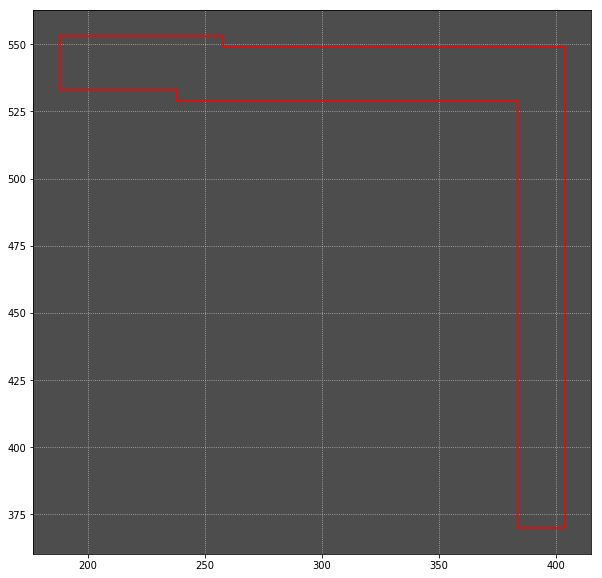

ValueError: Recived not a list.

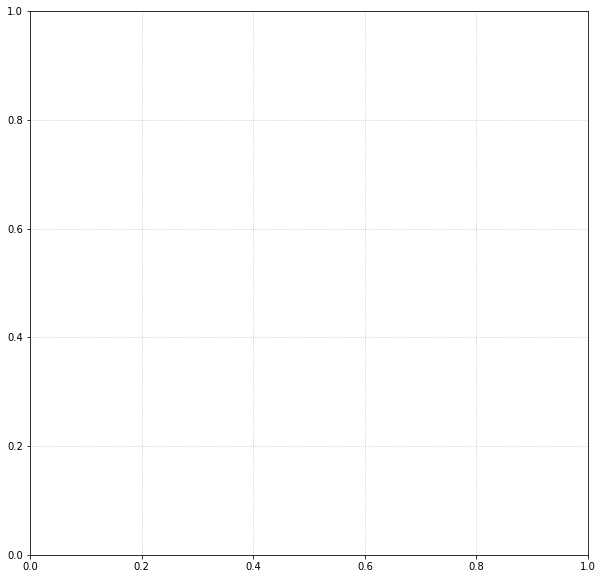

In [15]:
render(Conductor1=Conductor1[0][4])
render(Conductor1=smooth(optimze(ret=Conductor1[0][4])['ret'][0]))
print(Conductor1[0][4])
print("")
print(optimze(ret=Conductor1[0][4])['ret'])
print("")
print(smooth(optimze(ret=Conductor1[0][4])['ret'][0]))

In [ ]:
tr=U1_pad[0]
print("tr",tr)
tre=expand(tr,at)
print("tre",tre)
render(Conductor1=tr,Silk=tre)

In [ ]:
tpp=[0,0]
print("tpp",tpp)
tp=alignment_pad(tpp)
print("tp",tp)
render(Silk=tp)
tr=rect(-25,-25,50,50)
print("tr",tr)
render(Silk=tr)
tpexp=expand(tp,at)
render(Silk=tpexp)
trexp=expand(tr,at)
render(Silk=trexp)